<a href="https://colab.research.google.com/github/QDDse/petsavage/blob/main/DL_Deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.9 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 189 kB 46.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 265 kB/s 


####### 这行代码实现挂载谷歌云端，提供对Google 云端硬盘的访问权限以保存文件和图像 

```
# from google.colab import drive
drive._mount('/content/drive')
```





In [2]:
# from google.colab import drive
# drive._mount('/content/drive')

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import*
from fastai.vision.widgets import*


Mounted at /content/gdrive


#### 下载数据集

```
# git clone https://github.com/ieee8023/covid-chestxray-dataset.git 
  下载covid-19 imagesets 到content父目录下
```



In [ ]:
# !git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [ ]:
# path = Path('/content/covid-chestxray-dataset/images')
# #将将数据集位置的路径保存在Path()对象中。如果使用fast.ai数据集，则可以使用以下代码：
# path = untar_data(URLs.PETS)/'images'
# # 检查图像路径并显示数据集中的一些样本图像
# path_pet = untar_data(URLs.PETS/'images')

In [3]:
path_pet = untar_data(URLs.PETS)
path_pet.ls()
files = get_image_files(path_pet/"images")
len(files)  #7390

7390

In [4]:
files[100],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_179.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_3.jpg'))

In [5]:
# 定义一个label function
def label_func(f):
  if f[0].isupper():  # 判断字符是否为大写
    return 'Cat'
  else:
    return 'Dog'

#### Images Transform
- 又叫图像扩充，为了避免模型overfit。
- 调整大小、裁剪、压缩、填充
- 压缩和填充会抢夺图像中的原始信息

In [6]:
item_tfms =  Resize(128,ResizeMethod.Squish)
item_tfms = Resize(128,ResizeMethod.Pad,pad_mode='zero')
item_tfms =  RandomResizedCrop(128,min_scale=0.3)#-30% of the image area is zoomed by specifying 0.3

# fastai 通过aug_transforms函数提供了一组标准的扩充。size均匀可以批量应用
tfms = aug_transforms(do_flip=True,flip_vert=False,mult=2.0)

#### DataLoader 类便于存储用于训练和验证模型的各种对象
- 如果要自定义，可以将其与DataBlock class结合使用

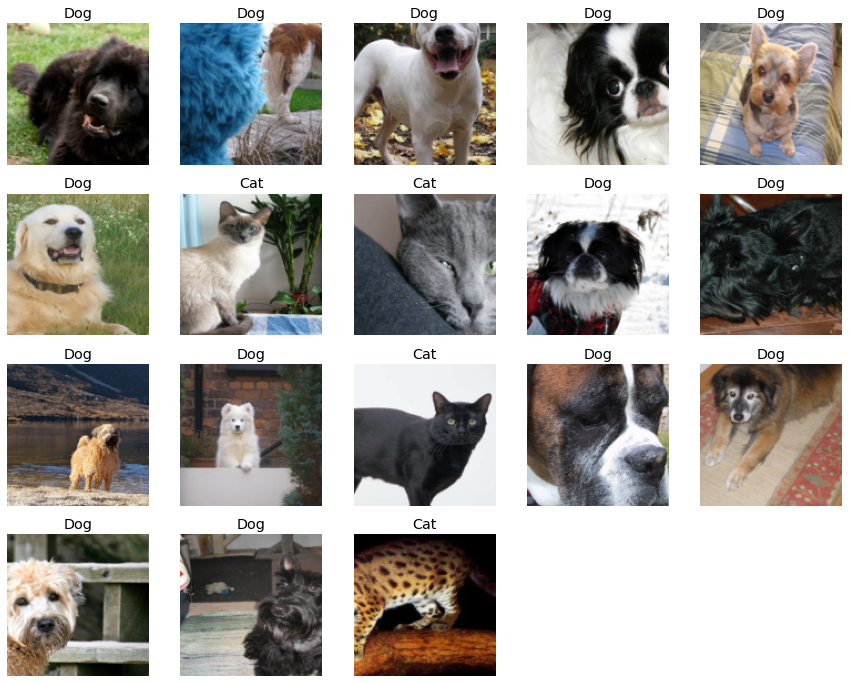

In [7]:
# 从name_func导入dataloader，label_func--标签函数
dls_pet = ImageDataLoaders.from_name_func(path_pet,files,label_func,item_tfms=item_tfms) 
dls_pet.show_batch(max_n=18)   


In [21]:
# 查看labels
# path_pet.ls()
# import pandas as pd
# label_pet = pd.read('/root/.fastai/data/oxford-iiit-pet/annotations')

AttributeError: ignored

#### k-folds交叉验证


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

# N_fold = 5
# seed = 999
# strat_kfold = StratifiedKFold(n_splits=N_fold,random_state=seed,shuffle=True)
# for i in strat_kfold.split(dls_pet):
#   print(i)

#### 模型训练
- 为了训练图像数据集，使用了预训练的CNN model（迁移学习）。
- 用于加快训练速度

In [ ]:
#### 清理memory
# import gc
# gc.collect()
# del learn_pet

In [22]:

learn_pet = cnn_learner(dls_pet,resnet101,metrics=error_rate)
learn_pet.fine_tune(8)
# 导出learner_pet.pkl
learn_pet.export(fname='/content/gdrive/MyDrive/learn_petv2.pkl')

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.245762,0.114725,0.033153,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.087780,0.035648,0.014208,01:58
1,0.073117,0.055385,0.017591,01:58
2,0.064170,0.050167,0.014208,01:58
3,0.058273,0.037422,0.014208,01:58
4,0.038664,0.025391,0.010825,01:58
5,0.023012,0.030250,0.011502,01:58
6,0.019797,0.026773,0.010825,01:58
7,0.014461,0.026603,0.011502,01:58


In [24]:
#加载pkl checkpoint
learn_pet_v2 = load_learner('/content/gdrive/MyDrive/learn_pet.pkl')
learn_pet_v2

#### 模型训练
- 为了训练图像数据集，使用了预训练的CNN model（迁移学习）。
- 用于加快训练速度

#### 验证模型性能
- 验证性能通过不同的方式进行，一种很流行的方式是使用**混淆矩阵** ，矩阵的对角线值指示每种类别的正确preds，而其他单元格指示许多错误的preds。
- 可以直接计算recall and error

In [ ]:
# preds,y,losses = learn_pet.get_preds(with_loss=True)
# interp_pet = ClassificationInterpretation(learn_pet_v2,preds,y,losses=losses,decoded=True,targs=)
# preds

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn_pet)
# interp.plot_confusion_matrix()

##### Fastai 提供了一个有用的功能，可以根据最高丢失率查看错误的预测。该函数的输出指示每个image的预测标签、目标标签、丢失率、概率值。高概率表示模型具有较高的置信度，【0,1】

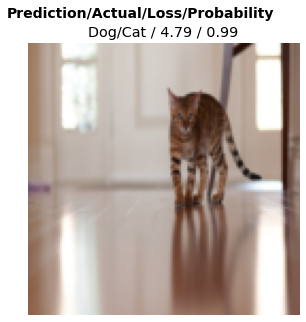

In [12]:
interp.plot_top_losses(1,nrows=1,figsize=(25,5))

- ImageClassifierCleaner(GUI),可以通过删除故障image或重命名labels来清楚故障。
- 适合在数据预处理，提高模型准确

In [ ]:
# from fastai.vision.widgets import*
# cleaner = ImageClassifierCleaner(learn_pet)
# cleaner

#### 保存并部署模型
- 先导出为PKL文件（pickle）

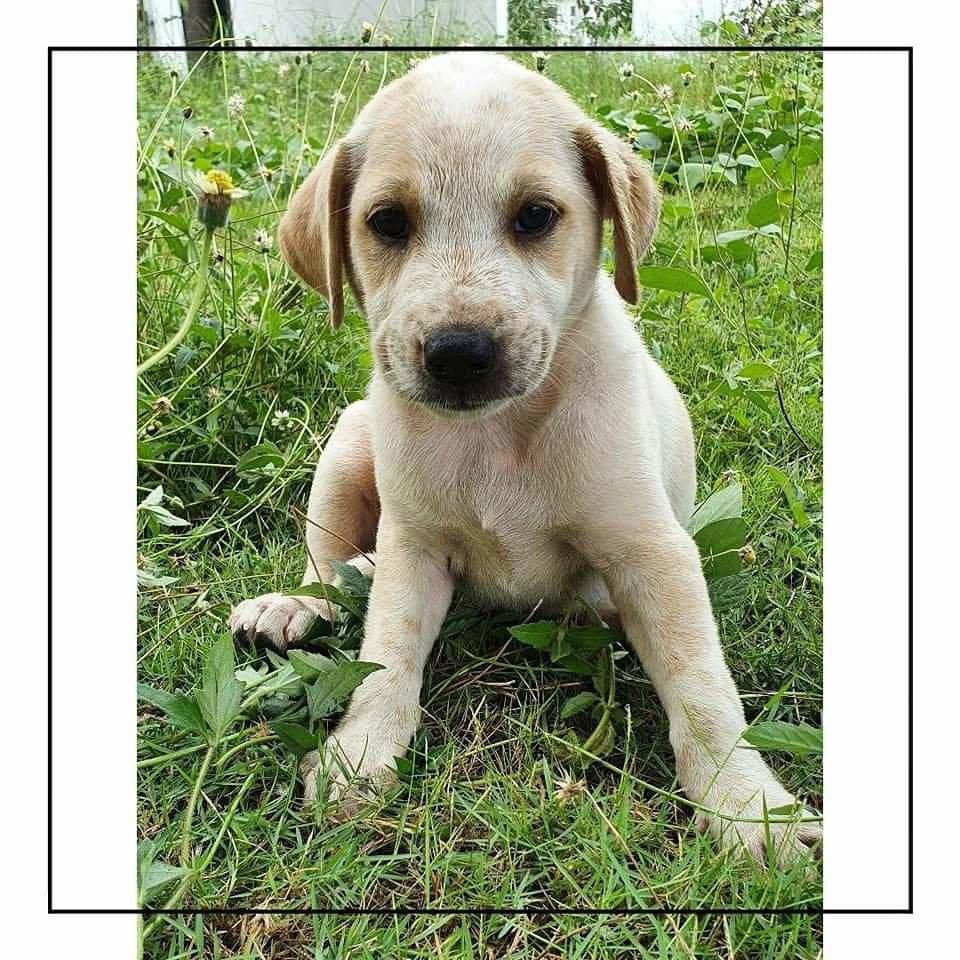

In [27]:
path_pet.ls()
from PIL import Image
img = Image.open('/content/gdrive/MyDrive/Dog.jpg')
img

- 有多种方式可以创建用于部署模型的web app。
- 最简单的方式之一是使用作为GUI组价的python小部件在jupyter notebook中为app创建所需的对象

In [43]:
from fastai.vision.widgets import*
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description = 'Classify')

#### 在web app中一样运行notebook的Voila来部署模型。

In [29]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 396 kB 31.2 MB/s 
     |████████████████████████████████| 111 kB 41.5 MB/s 
     |████████████████████████████████| 556 kB 35.1 MB/s 
     |████████████████████████████████| 129 kB 31.9 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 428 kB 48.4 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [ ]:
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#输出
out_pl

Output()

In [ ]:
# 预测
lbl_pred

Label(value='')

In [44]:
# on_click  函数
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[0])
  out_pl.clear_output()
  with out_pl:display(img.to_thumb(128.128))
  pred,pred_idx,probs = learn_pet_v2.predict(img)
  lbl_pred.value = f'Prediction:{pred};Probability:{probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [45]:
VBox([widgets.Label('Select a Image'),btn_upload,btn_run,out_pl,lbl_pred])

In [ ]:
# data = ImageDataLoaders.from_folder(path,train="train",valid_pct=0.2,item_tfms=Resize(128),batch_tfms=tfms,bs=30,num_works=4)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [ ]:
# # 图元文件中定义labels，可以用DataBlock将image和labels分为两个不同的块
# Data = DataBlock(blocks=(ImageBlock,CategoryBlock),get_items=get_image_files,splitter=RandomSplitter(valid_pct=0.2,seed=42),
# get_y=parent_label,item_tfms=Resize(128))

# dls = Data.dataloaders(path)